In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
sns.set_context("talk")

# CHECK HOW MANY STRUCTURES WE HAVE RETRIEVED

Per family, collect how many sequences it has, how many have been found with mmseqs, and how many structures we have downloaded. This will allow to see how much we loose in each step. 

In [2]:
# Load sequence summary 
summary_homfam = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))
summary_nseq = summary_homfam[["file_combined","n_sequences_combined"]]
summary_nseq = summary_nseq.rename(columns ={"file_combined": "family", "n_sequences_combined":"tot_n_sequences"})

In [3]:
# Load mmseqs summary 
mmseqs_summary = pd.DataFrame()
hits_path="/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/pdbs/structures/search_hits/mmseqs/*/*.UniProtKB/filtered_hits.m8"
hits_path="/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/filtered_ids/UniProtKB/id_0.9_cov_1.0/*/*filtered_hits.m8"
for file in glob.glob(hits_path):
    family = os.path.basename(os.path.dirname(file))
    hits_df = str_seatoxin = pd.read_csv(file, sep='\t', header = None)
    hits_df["family"] = family
    hits_df = hits_df.rename(columns = { 0: "mmseqs_found"})
    summary=summary = hits_df[["family", "mmseqs_found"]]
    mmseqs_summary = pd.concat([mmseqs_summary, summary])
mmseqs_summary_n = mmseqs_summary.groupby("family").count().reset_index()
#mmseqs_summary_n.head(2)

In [4]:
# Load structures summary 
str_summary = pd.DataFrame()
str_path = "/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/DB/structures/UniProtKB/*/*.pdb"
for file in glob.glob(str_path):
    family = os.path.basename(os.path.dirname(file))
    structure = os.path.basename(os.path.basename(file)).replace(".pdb", "")
    entry = pd.DataFrame({'family':[family], 'structure': structure})
    str_summary =  pd.concat([str_summary, entry], ignore_index = True)
summary_nstr = str_summary.groupby("family").count().reset_index()
summary_nstr = summary_nstr.rename(columns ={"structure":"structures_found"})

In [5]:
# Merge all results
#summary_n = pd.merge(summary_nseq, mmseqs_summary_n, on = "family")
summary_n = pd.merge(summary_nseq, summary_nstr, on = "family")

#summary_n["mmseqs_missing"] = summary_n["tot_n_sequences"] - summary_n["mmseqs_found"]
#summary_n["mmseqs_perc_missing"] = summary_n["mmseqs_missing"] * 100 / summary_n["tot_n_sequences"]

summary_n["structures_missing"] = summary_n["tot_n_sequences"] - summary_n["structures_found"]
summary_n["structures_perc_missing"] = summary_n["structures_missing"] * 100 / summary_n["tot_n_sequences"]

summary_n.sort_values(by = "family")

,family,tot_n_sequences,structures_found,structures_missing,structures_perc_missing
3,Acetyltransf,46285,23333,22952,49.588420
5,az,1086,1012,74,6.813996
2,blmb,17200,13319,3881,22.563953
4,cryst,1160,1061,99,8.534483
0,hip,167,167,0,0.000000
1,seatoxin,93,89,4,4.301075


In [6]:
summary_n = summary_n.sort_values("tot_n_sequences")
melted_summary = pd.melt(summary_n[["family", "tot_n_sequences", "mmseqs_found", "structures_found"]],  id_vars=['family'], value_name='N')

KeyError: "['mmseqs_found'] not in index"

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="N", y="family", data=melted_summary, hue = "variable",palette="rocket")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# Investigate why we don't retrieve all structures

In [10]:
# Take one example (profilin) and investigate why I don't retrieve all 
fam = "ghf11"
summary_nseq[summary_nseq.family == fam]
hits_fam_file =glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/filtered_ids/UniProtKB/id_0.9_cov_1.0/"+fam+"/*filtered_hits.m8")
hits_fam = pd.read_csv(hits_fam_file[0], sep='\t', header = None)

In [18]:
ids_to_downlad =glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/filtered_ids/UniProtKB/id_0.9_cov_1.0/ghf11/ghf11_ids_to_download.txt")
ids_to_downlad = pd.read_csv(ids_to_downlad[0], sep = ",", header = None)

In [40]:
template = glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/filtered_ids/UniProtKB/id_0.9_cov_1.0/ghf11/ghf11_template.txt")
template =  pd.read_csv(template[0], sep = " _P_ ", header = None)
template[0] = template[0].str.replace(">", "")
template[0] = template[0].str.replace("/", "_")

/tmp/ipykernel_12123/2632650797.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template =  pd.read_csv(template[0], sep = " _P_ ", header = None)


In [12]:
matched = set(mmseqs_summary[mmseqs_summary.family == fam ]["mmseqs_found"])
matched = set([sub.replace('/', '_') for sub in matched])
downloaded = set(str_summary[str_summary.family == fam ]["structure"])

In [13]:
missing = matched-downloaded

In [14]:
missing

{'B1A4I1_BACPU_36-221',
 'C9N599_9ACTO_58-239',
 'D1Z855_SORMA_38-218',
 'Q00263_9PLEO_44-224',
 'Q0U2J3_PHANO_44-224',
 'Q0UBV5_PHANO_18-195',
 'Q45VU2_BACSU_27-212',
 'Q45VU8_PAEMA_27-212',
 'Q9C1R1_FUSOX_48-228',
 'Q9HGT9_TRIRE_1-71',
 'Q9HGU0_ASPNG_1-71',
 'Q9UVY9_PHANO_2-123'}

In [154]:
ids_to_downlad

,0
0,C6F1J6
1,P09850
2,A0T2F0
3,F8W669
4,O43097
...,...
444,A0A4S2VPW4
445,P26220
446,P54865
447,O97402


In [47]:
template[template[0] == "C9N599_9ACTO_58-239"]

,0,1
211,C9N599_9ACTO_58-239,A0A8D3WQ19


In [50]:
ids_to_downlad[ids_to_downlad[0] == "A0A8D3WQ19"]

,0
201,A0A8D3WQ19


In [69]:
summary_n = summary_n.sort_values("mmseqs_perc_missing")
melted_summary_missing = pd.melt(summary_n[["family", "mmseqs_perc_missing", "structures_perc_missing"]],  id_vars=['family'], value_name='N')

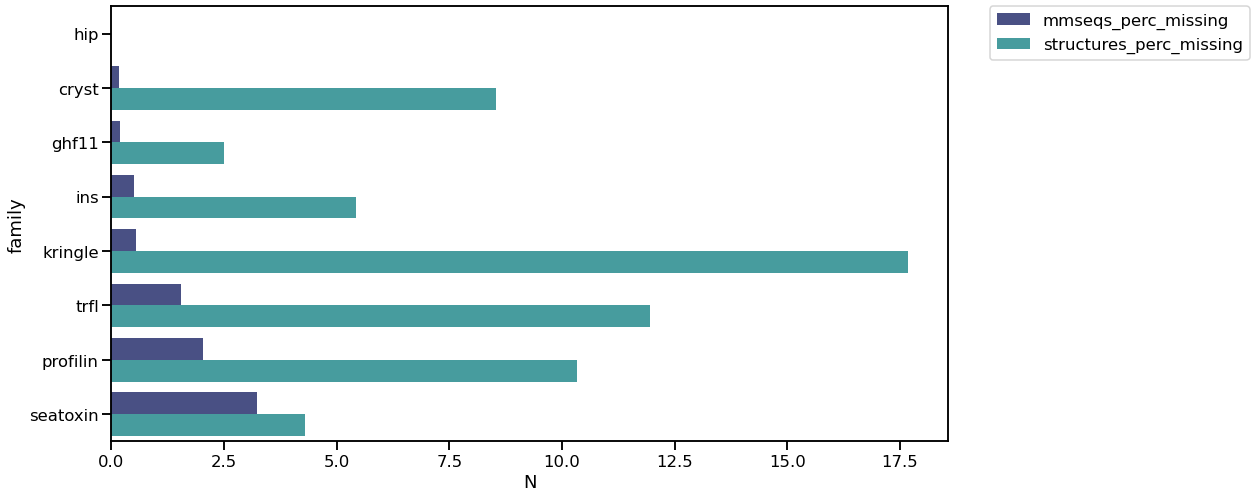

In [71]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="N", y="family", data=melted_summary_missing, hue = "variable",palette="mako")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# TODO: 
- Why are not all the structures downloaded? 

In [ ]:
>A0T2F0_TRIVI/50-227 _P_ A0T2F0

In [ ]:
>A0T2F0_TRIVI/50-227
RRASINYDQNYQTGGQVSYSPSNTGFSVNWNTQDDFVVGVGWTTGSSAPINFGGSFSVNS
GTGLLSVYGWSTNPLVEYYIMEDNHNYPAQGTVKGTVTSDGATYTIWENTRVNEPSIQGT
ATFNQYISVRNSPRTSGTVTVQNHFNAWASLGLHLGQMNYQVVAVEGWGGSGSASQSV

In [117]:
string = "RRASINYDQNYQTGGQVSYSPSNTGFSVNWNTQDDFVVGVGWTTGSSAPINFGGSFSVNSGTGLLSVYGWSTNPLVEYYIMEDNHNYPAQGTVKGTVTSDGATYTIWENTRVNEPSIQGTATFNQYISVRNSPRTSGTVTVQNHFNAWASLGLHLGQMNYQVVAVEGWGGSGSASQSV"

In [118]:
len(string)

178

In [131]:
PDBFile = "/home/luisasantus/Desktop/test.pdb"

In [132]:
import sys
from Bio import SeqIO

with open(PDBFile, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        print('>' + record.id)
        print(record.seq)


>????:A
MVAFSSLICALTSIASTLAMPTGLEPESSVNVTERGMYDFVLGAHNDHRRRASINYDQNYQTGGQVSYSPSNTGFSVNWNTQDDFVVGVGWTTGSSAPINFGGSFSVNSGTGLLSVYGWSTNPLVEYYIMEDNHNYPAQGTVKGTVTSDGATYTIWENTRVNEPSIQGTATFNQYISVRNSPRTSGTVTVQNHFNAWASLGLHLGQMNYQVVAVEGWGGSGSASQSVSN


/home/luisasantus/anaconda3/lib/python3.9/site-packages/Bio/SeqIO/PdbIO.py:303: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


In [133]:
str_fa = "MVAFSSLICALTSIASTLAMPTGLEPESSVNVTERGMYDFVLGAHNDHRRRASINYDQNYQTGGQVSYSPSNTGFSVNWNTQDDFVVGVGWTTGSSAPINFGGSFSVNSGTGLLSVYGWSTNPLVEYYIMEDNHNYPAQGTVKGTVTSDGATYTIWENTRVNEPSIQGTATFNQYISVRNSPRTSGTVTVQNHFNAWASLGLHLGQMNYQVVAVEGWGGSGSASQSVSN"

In [134]:
len(str_fa)

229